# Airbnb: Network of Suspicious hosts

(Link to the presentation - http://tiny.cc/rp2iuz)

## Objective

Identify networks of suspicious hosts with duplicate/ fake listings connected by fake reviewers using network analysis & Levenshtein distance.

## Problem statement

Hosts on Airbnb create fake listings for numerous reasons such as

- To by-pass the 30/90 nights limit in countries such as Amsterdam or London
- Defraud the guests by using "bait and switch" method which involves double booking and last minute rescheduling to another listing
- If a listing has multiple negative reviews, it is a better option for the hosts to create another listing with some of the details changed
- Create multiple listings with fake reviewers leaving positive reviews to boost the ranking of the host

## Approach

The core assumption here is the hosts uses fake reviewers to leave positive reviews on his/her listings. This way, the host can quickly get some credibility around the new listing. Following are the steps involved in identifying these suspicious hosts -

- Step 1: Fetch the "listings" and "reviews" dataset for Amsterdam and London until July 2021 from ["Inside Airbnb"](http://insideairbnb.com/)
- Step 2: Use NetworkX to create a bi-partite graph that connects host_id and reviewer_id using listing_id as a bridge
- Step 3: Once "related" hosts are identified, pick the reviews - compute polarity score for each review and generate different word clouds for positive and negative reviews. 
We are trying to understand if the negative reviews contain words like "fraud" or "scam" which could be posted by a genuine reviewer or contains repetitive positive words (across different listings) which could be posted by a suspected fake reviewer.
- Step 4: Fetch the suspected hosts and listings, and run Levenshtein distance or any other similarity measure on features such as names, address, phone number, location, listing pictures etc.
- Step 5: Finally, we can infer with a certain confidence that X hosts are actually fake or running a scam listing operation. We can also compute the revenue lost by genuine customers staying at the listing and having a bad experience.

## Visualizing example scenario
<br>

<img src="../img/example_scenario.png">

<br>
For example, let's consider the following scenario

- Host 1 has 3 listings and each listing has multiple positive reviews from Reviewer 1
- Reviewer 1 has similarly left positive reviews on other listings (Listings 4,5) by another host, Host 2
- In this scenario, Reviewer 1 looks suspicious and we can further investigate the nature of these 5 listings
- We can say, with certain confidence that Host 1 and Host 2 are accounts owned by same person or company and has multiple duplicate listings. These listings are reviewed by another set of fake reviewers.

## Solution
### 1. Data Preparation

In [27]:
# Importing necessary libs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import networkx as nx
from pyvis.network import Network
from networkx.algorithms import bipartite
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

### 1.1 Airbnb Reviews Data

In [4]:
# Loading reviews dataset from "Inside Airbnb" for London & Amsterdam until July 2021

df_reviews = pd.read_csv('reviews_lon_jul21.csv')
df_reviews.shape

(1073056, 6)

In [5]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...
2,11551,41044,2010-05-09,104133,Chase,Adriano was a fantastic host. We felt very at ...
3,11551,48926,2010-06-01,122714,John & Sylvia,We had a most wonderful stay with Adriano and ...
4,11551,58352,2010-06-28,111543,Monique,I'm not sure which of us misunderstood the s...


In [6]:
# drop null comments
df_reviews.dropna(inplace=True)
df_reviews.shape

# drop reviews containing 'This is an automated posting'
automated = df_reviews[df_reviews.comments.str.contains('This is an automated posting')].index
df_reviews.drop(index=automated, inplace=True)
df_reviews.shape

(1054542, 6)

---------
### 1.2 Airbnb Listings Data

In [7]:
# Loading listings dataset from "Inside Airbnb" for London & Amsterdam until July 2021
df_listings_full = pd.read_csv('listings_lon_jul21.csv')
df_listings_full.shape

(73364, 74)

In [8]:
df_listings_full.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20210706215658,2021-07-08,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments my flat gives yo...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,...,4.85,4.53,4.52,NaN,f,3,3,0,0,1.63
1,13913,https://www.airbnb.com/rooms/13913,20210706215658,2021-07-08,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,...,4.89,4.63,4.74,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20210706215658,2021-07-08,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,...,4.82,4.93,4.73,NaN,t,1,1,0,0,0.81
3,17402,https://www.airbnb.com/rooms/17402,20210706215658,2021-07-08,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,https://www.airbnb.com/users/show/67564,...,4.66,4.85,4.59,NaN,f,15,15,0,0,0.36
4,17506,https://www.airbnb.com/rooms/17506,20210706215658,2021-07-08,Boutique Chelsea/Fulham Double bed 5-star ensuite,Enjoy a chic stay in this elegant but fully mo...,Fulham is 'villagey' and residential – a real ...,https://a0.muscache.com/pictures/11901327/e63d...,67915,https://www.airbnb.com/users/show/67915,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN


For our usecase we only need listing_id, host_id and host_name

In [9]:
df_listings = df_listings_full[['id', 'host_id', 'host_name']]
df_listings.drop_duplicates(subset=['id', 'host_id'], inplace=True)
df_listings.shape

(73364, 3)

In [10]:
# create subsets with relevant columns for merging
df1 = df_reviews[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df2 = df_listings[['id', 'host_id', 'host_name']].copy()

# rename id as listing_id for merge
df2.rename(columns={'id': 'listing_id'}, inplace=True)

----------
### 1.3 Merge reviews and listings data

In [11]:
# merge dataframes
df = pd.merge(df1, df2, how='left', on='listing_id')
print(df.shape)
df.dropna(inplace=True)
df.drop_duplicates(subset=['id'], inplace=True)
print(df.shape)
df.reviewer_id = df.reviewer_id.astype(int)
df.info()

(1054542, 8)
(1052613, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052613 entries, 0 to 1054541
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1052613 non-null  int64 
 1   reviewer_id    1052613 non-null  int32 
 2   reviewer_name  1052613 non-null  object
 3   id             1052613 non-null  int64 
 4   date           1052613 non-null  object
 5   comments       1052613 non-null  object
 6   host_id        1052613 non-null  int64 
 7   host_name      1052613 non-null  object
dtypes: int32(1), int64(3), object(4)
memory usage: 68.3+ MB


In [12]:
# Export merged data to csv
df.to_csv('merged_data_lon.csv')

-----------------------
## 2. Exploratory Data Analysis

In [13]:
# # Group by Lat & Lon
# df_listings_lat_lon = df_listings_full.groupby(['latitude','longitude']).size().reset_index(name='no_of_listings')

# # Creating GeoMap based on Lat and Lon
# import plotly.express as px
# fig = px.density_mapbox(df_listings_lat_lon, lat='latitude', lon='longitude', z='no_of_listings', radius=10,
#                         center=dict(lat=0, lon=180), zoom=0,
#                         mapbox_style="stamen-terrain")
# fig.show()

### 2.1 Compute "Reviews per host" & "Reviews per reviewer"

In [14]:
# calculate reviews per host (no of reviews they are getting)
host_review_counts = df.groupby('host_id')[['listing_id']].count().reset_index()
host_review_counts.rename(columns={'listing_id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer (no of reviews they are giving)
reviewer_review_counts = df.groupby('reviewer_id')[['listing_id']].count().reset_index()
reviewer_review_counts.rename(columns={'listing_id': 'reviewer_review_count'}, inplace=True)

# calculate number of listings by host
host_listing_counts = df.groupby(['host_id', 'listing_id'])[['id']].count().reset_index().drop(columns=['id']) \
                        .groupby('host_id')[['listing_id']].count().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_count'}, inplace=True)

# calculate number of hosts reviewed by reviewer
reviewer_host_counts = df.groupby(['reviewer_id', 'host_id'])[['id']].count().reset_index().drop(columns=['id']) \
                         .groupby('reviewer_id')[['host_id']].count().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_count'}, inplace=True)

In [17]:
# merging to main df

df = pd.merge(df, host_review_counts, how='left', on='host_id')
df = pd.merge(df, reviewer_review_counts, how='left', on='reviewer_id')
df = pd.merge(df, host_listing_counts, how='left', on='host_id')
df = pd.merge(df, reviewer_host_counts, how='left', on='reviewer_id')
df.shape

(1052613, 12)

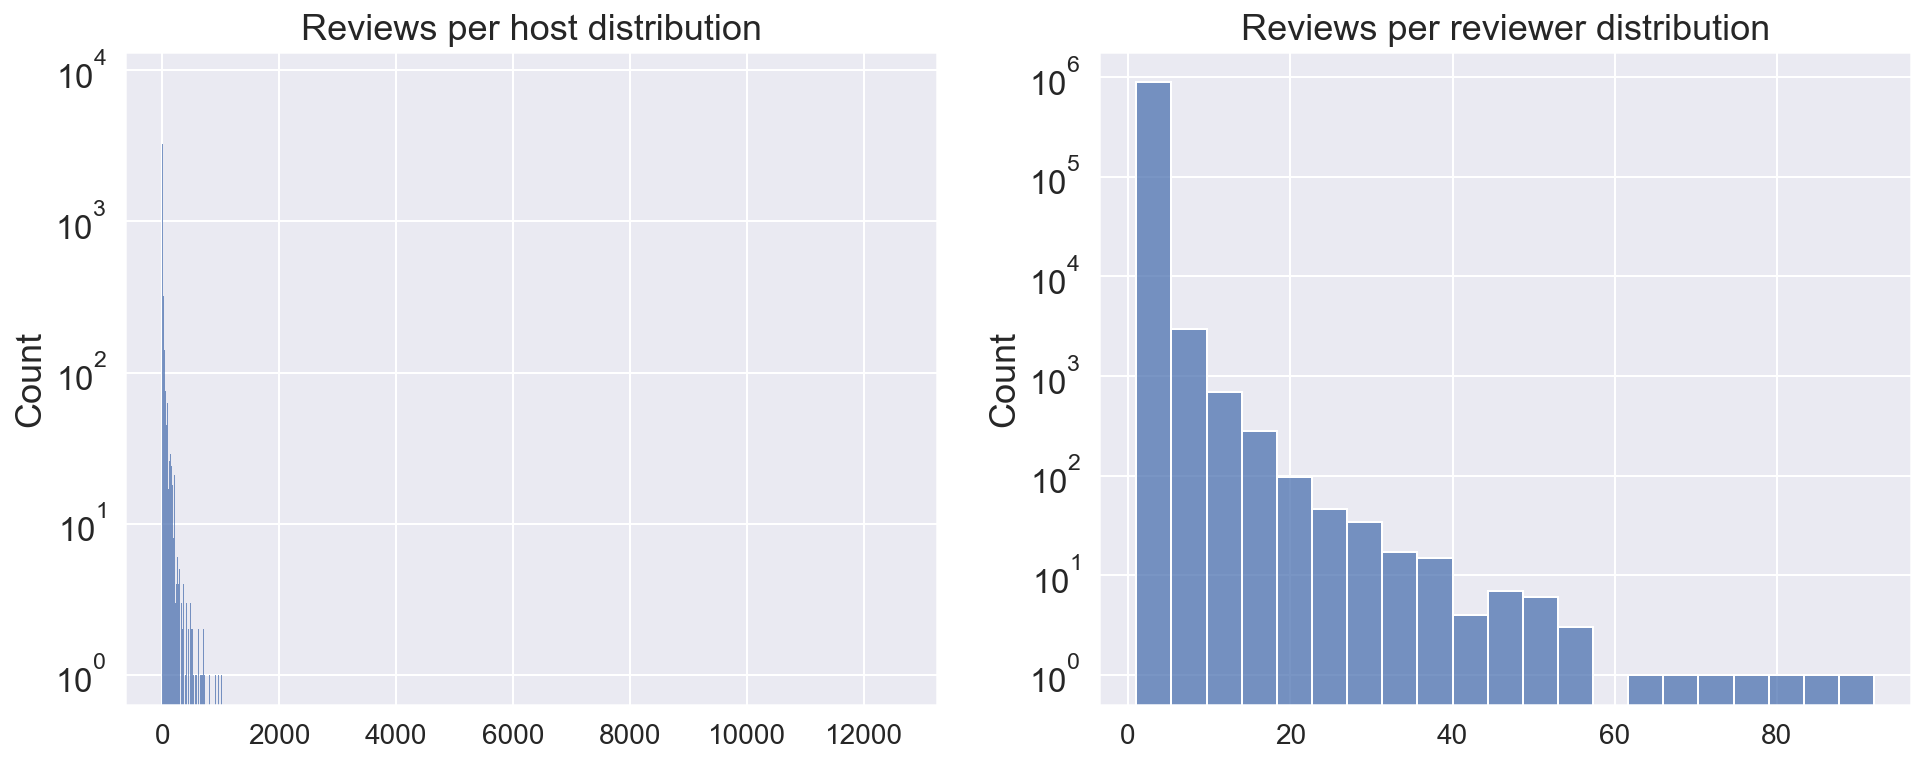

In [18]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
sns.histplot(host_review_counts.host_review_count, ax=ax[0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[1])
ax[0].set_title('Reviews per host distribution')
ax[1].set_title('Reviews per reviewer distribution')

for a in ax:
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=14, labelrotation=0)
    a.set_yscale('log')

plt.show()

### 2.2 Create subset of reviews and hosts to drain out noise 

- Only include hosts and reviewers where reviewers have left multiple reviews for a host (can be for different listings)
- Only include hosts with multiple listings
- Only include reviewers who have reviewed at least three hosts
- Exclude multiple reviews from a reviewer for a listing which occur on the same date

In [19]:
subset = df[df.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset = subset[subset.host_listing_count >= 5]
subset = subset[subset.reviewer_host_count > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False, inplace=True)
subset.shape

(3220, 12)

In [20]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  1001
Number of hosts:  339


----------
## 3. Using NetworkX 

In [21]:
# UDF
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 1]
    num_components = len(components)
    return components, num_components

def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

# create dictionary for labels
hosts = dict(subset[['host_id', 'host_name']].values)
reviewers = dict(subset[['reviewer_id', 'reviewer_name']].values)
labels_dict = {**reviewers, **hosts}

In [22]:
G = nx.Graph()
G.add_nodes_from(subset.reviewer_id.unique(), bipartite=0)
G.add_nodes_from(subset.host_id.unique(), bipartite=1)
G.add_edges_from(subset[['reviewer_id', 'host_id']].values)

In [24]:
print(nx.info(G))

Graph with 1340 nodes and 1148 edges


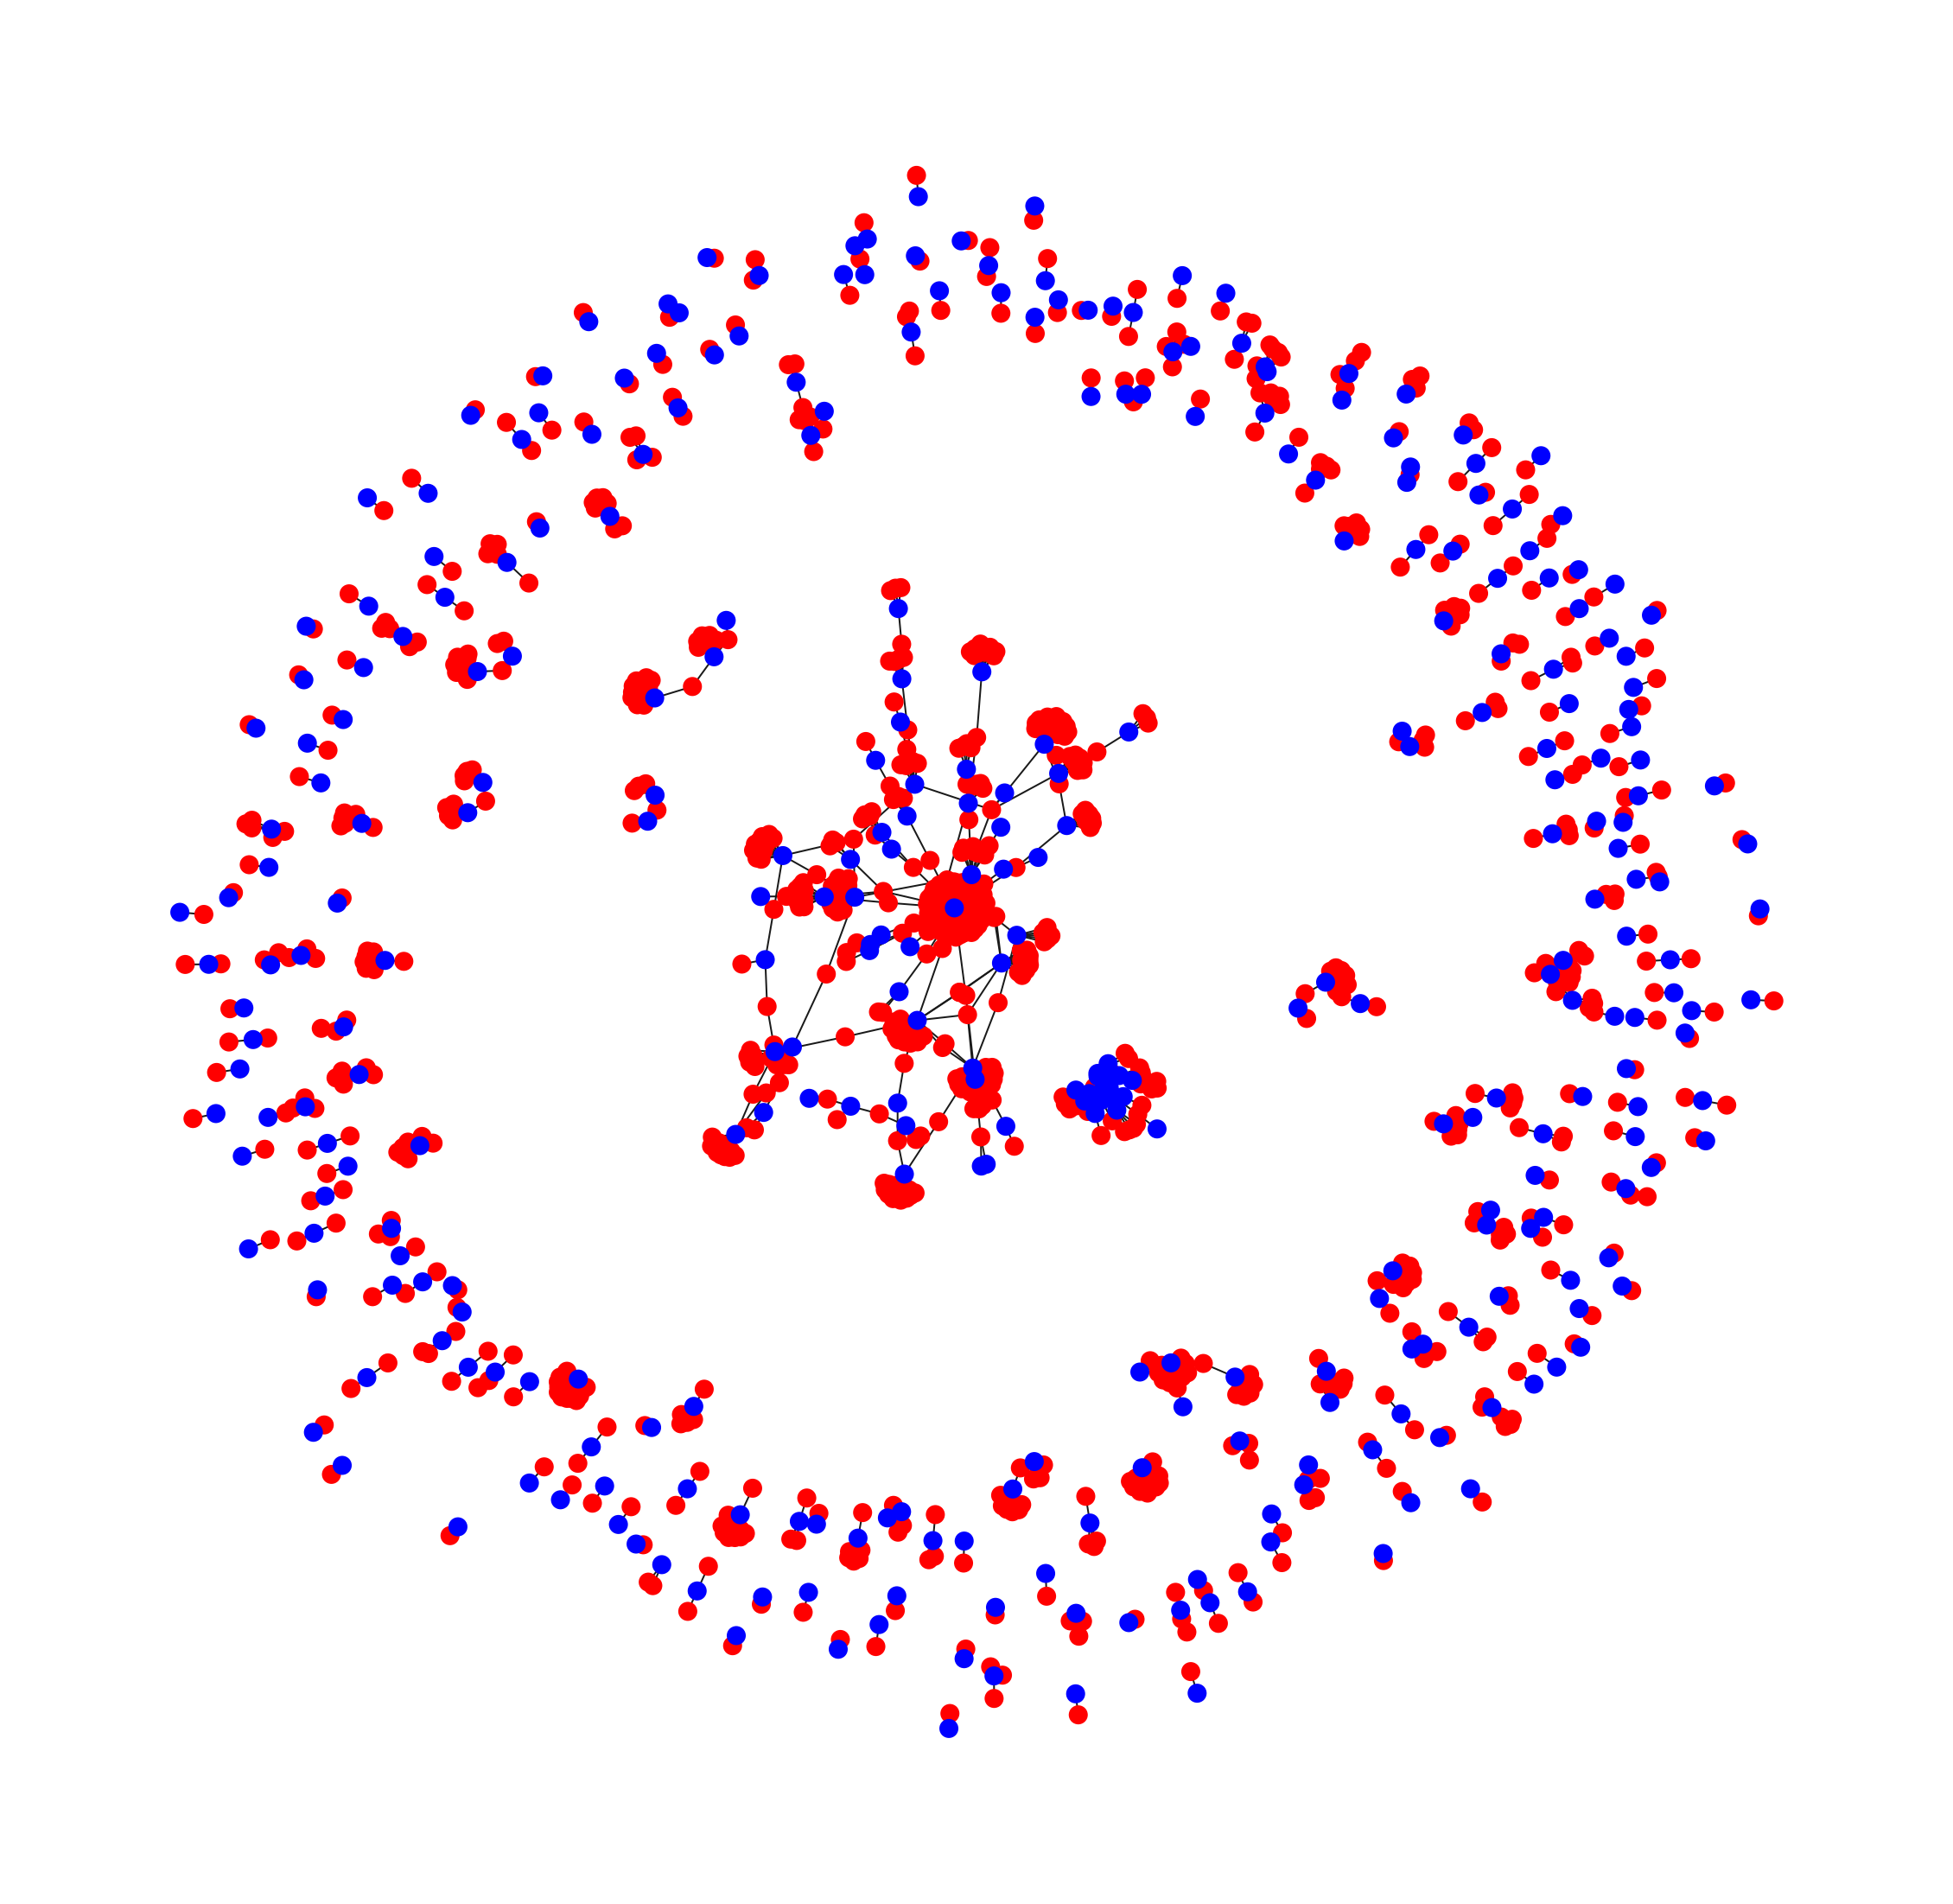

In [25]:
# nodes
reviewer_nodes = subset.reviewer_id.unique()
host_nodes = subset.host_id.unique()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=1)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

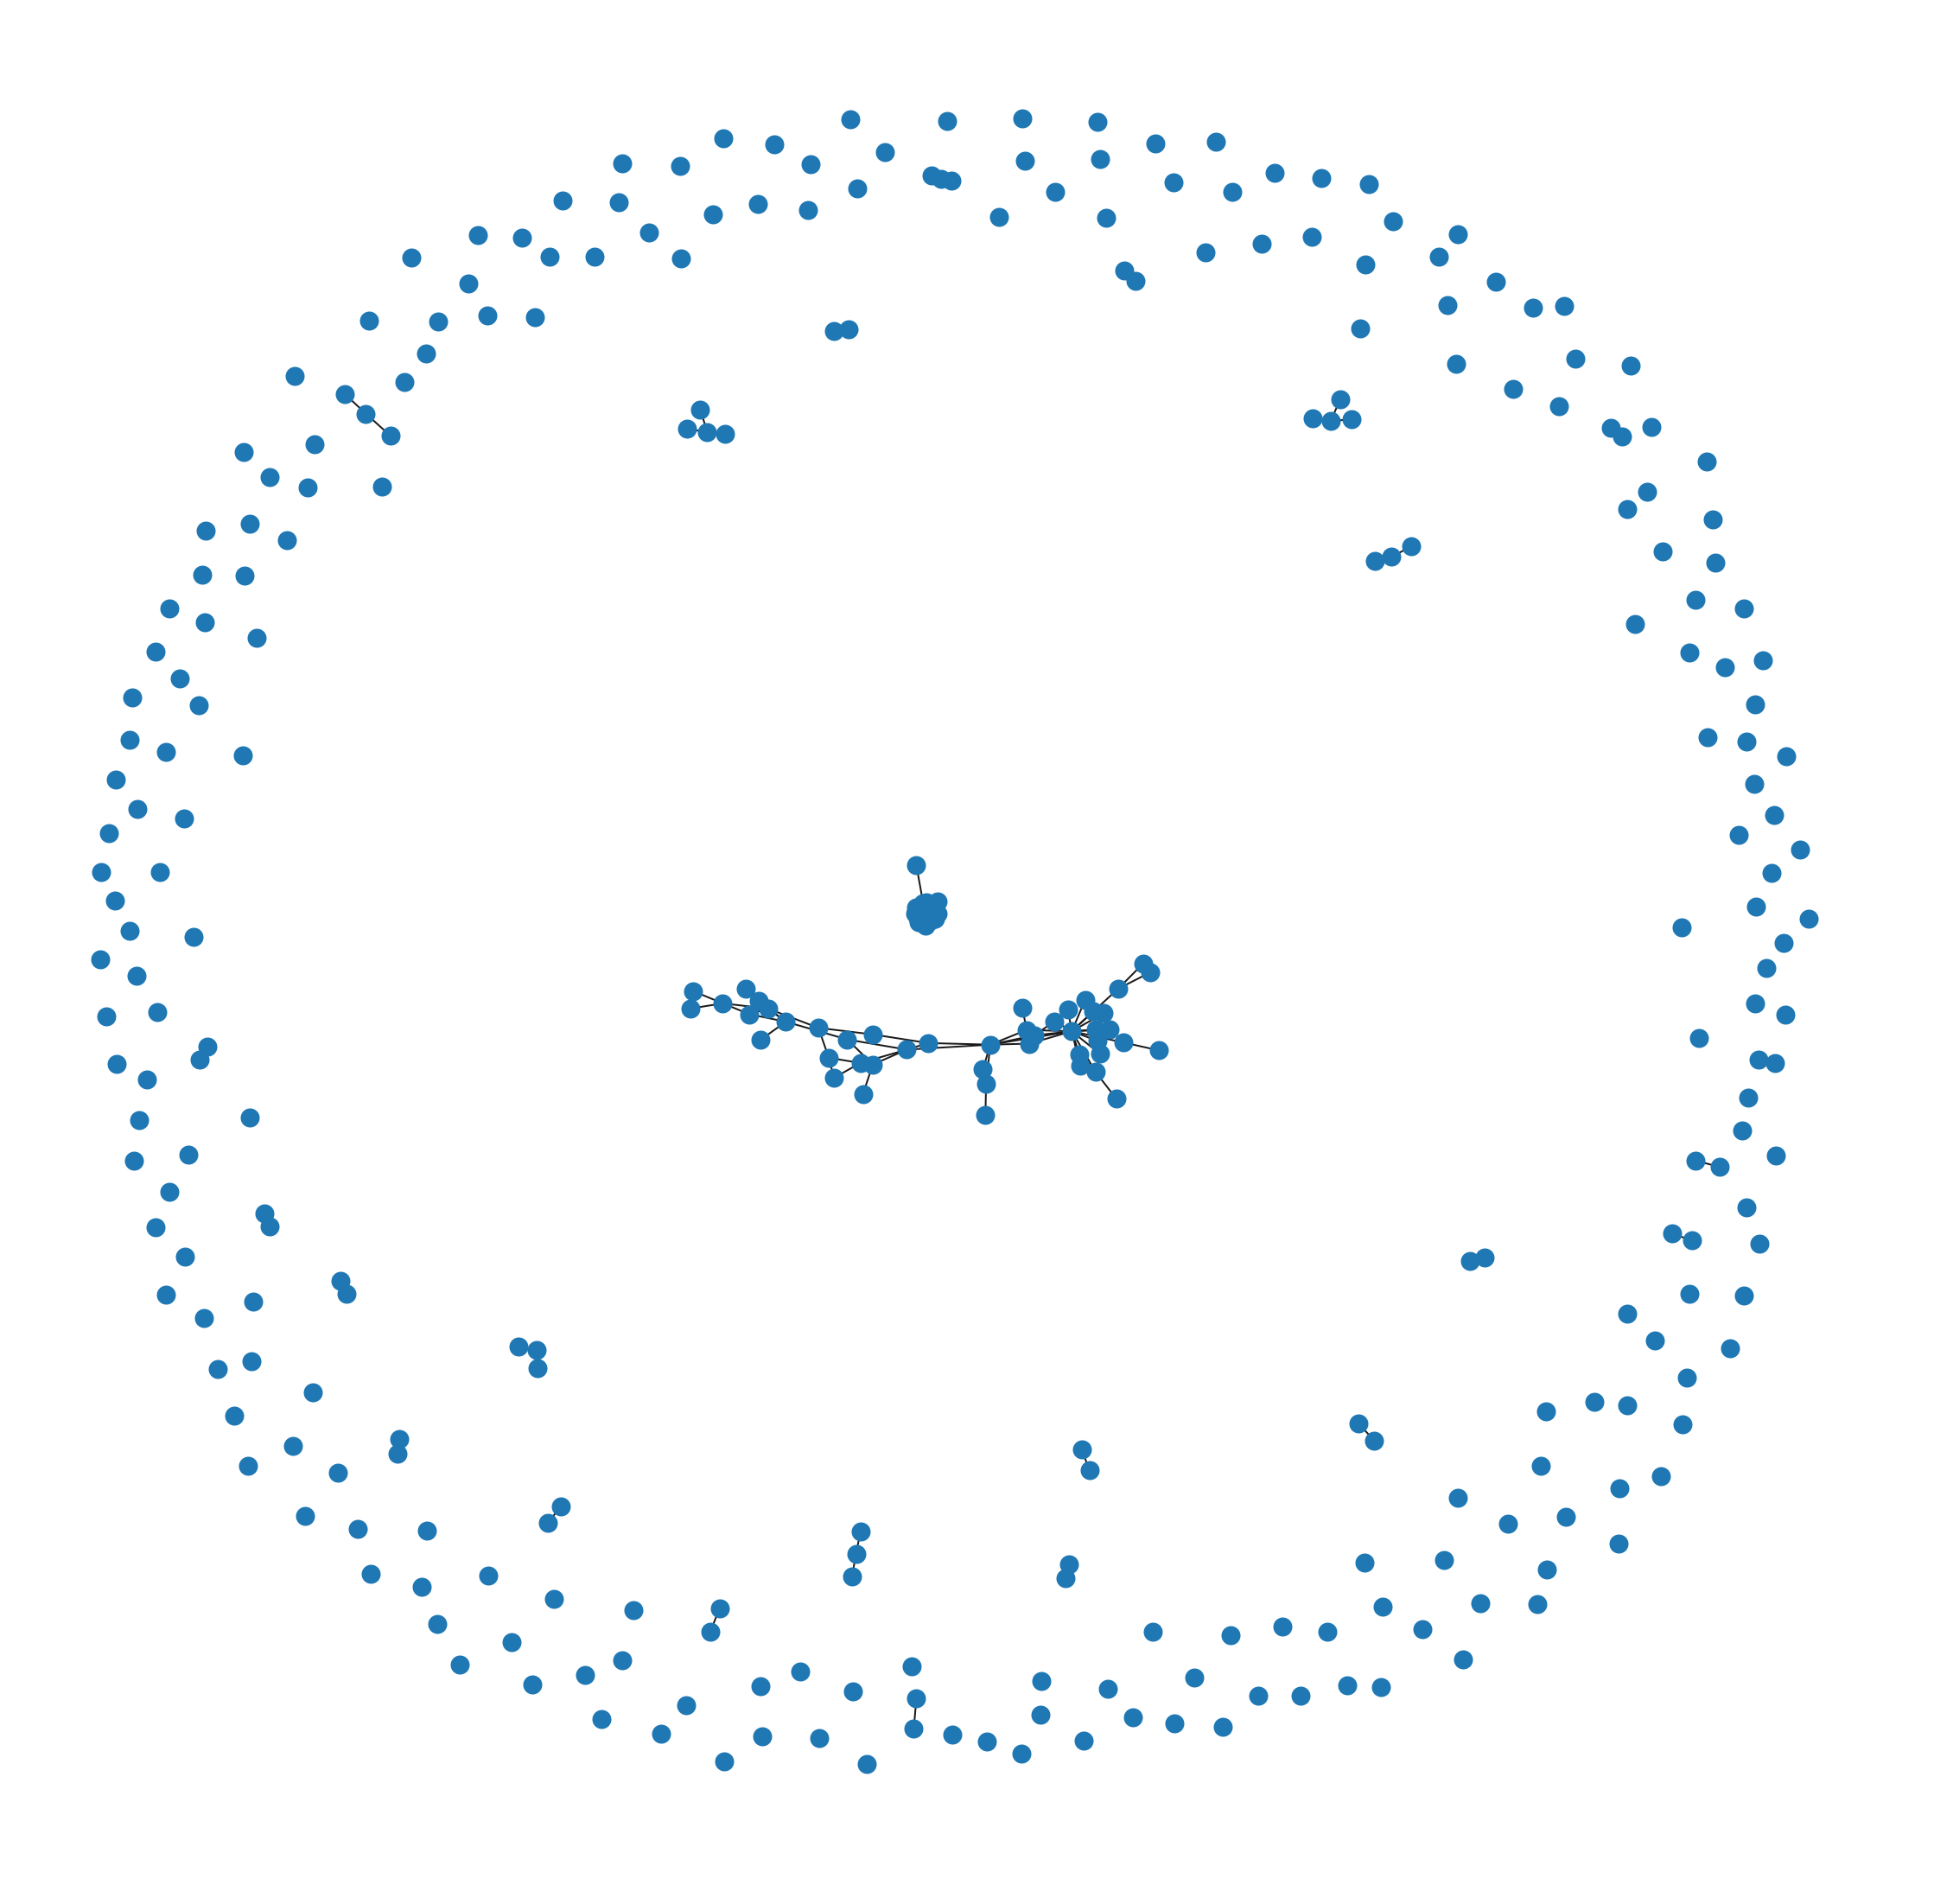

In [28]:
# look at projected graph (on hosts)
host_nodes = subset.host_id.unique()
B = bipartite.projected_graph(G, host_nodes)

pos = nx.spring_layout(B, seed=6)
labels = {node: labels_dict[node] for node in B.nodes}

# create plot
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

In [29]:
# identify the components with no links
components_one, n_one = component_size_one(B)
components_one = [item for sublist in components_one for item in sublist]

print("Number of components:\n", n_one)

Number of components:
 217


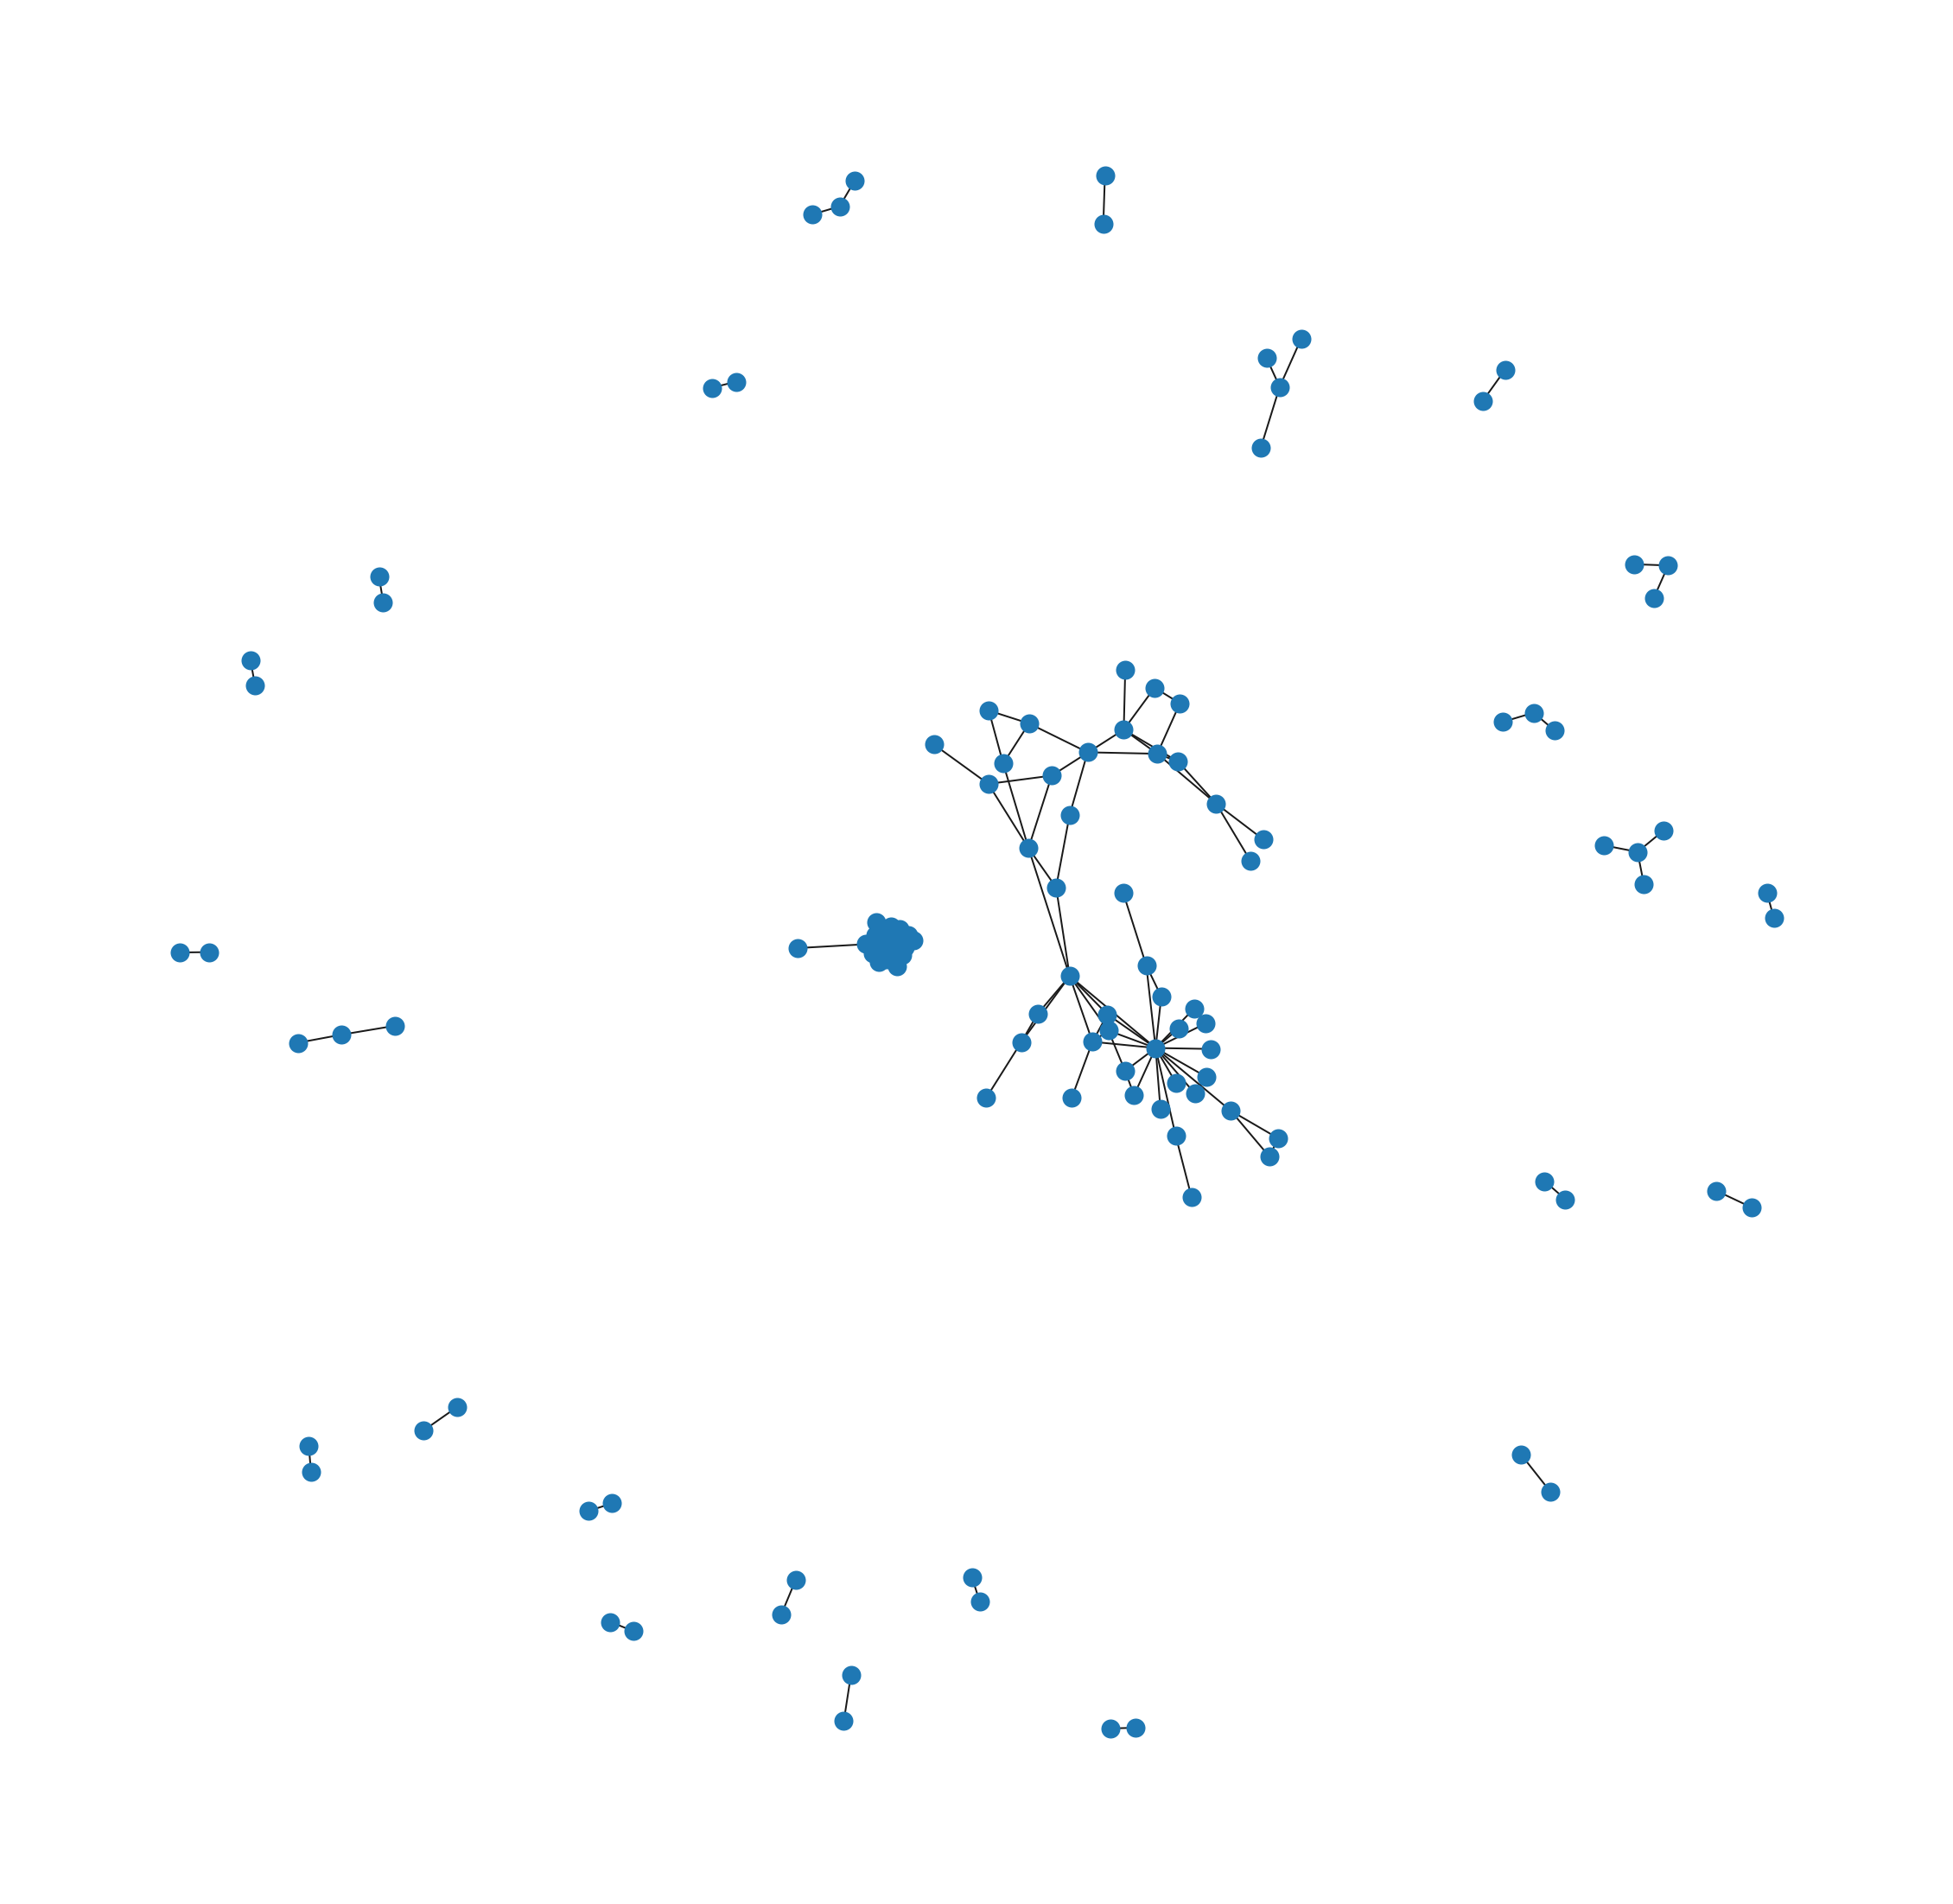

In [30]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)

pos = nx.spring_layout(B, seed=1)
labels = {node: labels_dict[node] for node in B.nodes}

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=11, font_family="sans-serif")
plt.axis("off")
plt.show()

### 3.1 Investigate some connected components

In [31]:
GCC, components, n = giant_component_size(B)
print("Number of components:\n", n)

Number of components:
 26


In [46]:
GCC, components, n = giant_component_size(B)
gcc_df = pd.DataFrame(GCC)
components_df = pd.DataFrame(components)

In [49]:
gcc_df.to_csv('gcc.csv')
components_df.to_csv('comp.csv')

In [61]:
gcc_df.rename(columns={0:'host_id'}, inplace=True)
gcc_df.head()

,host_id
0,27787137
1,20297348
2,13321221
3,9791627
4,28381203


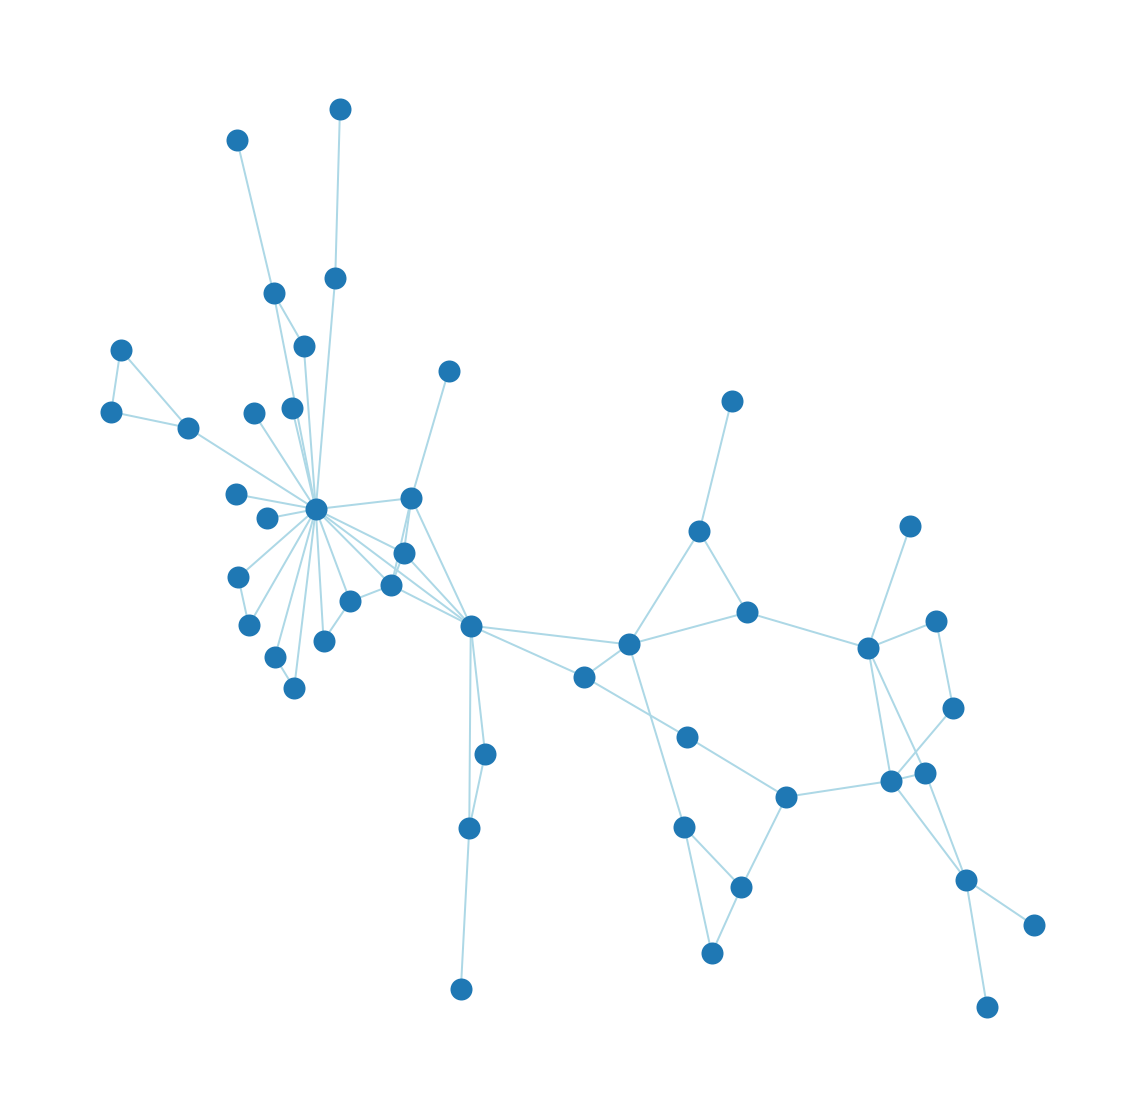

In [50]:
# plot one of the components
B_sub_1 = B.subgraph(components[1][1])

pos = nx.spring_layout(B_sub_1, seed=4)
labels = {node: labels_dict[node] for node in B_sub_1.nodes}

# create plot
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(B_sub_1, pos, node_size=100)
nx.draw_networkx_edges(B_sub_1, pos, width=1, edge_color='lightblue')
# nx.draw_networkx_labels(B_sub_1, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()

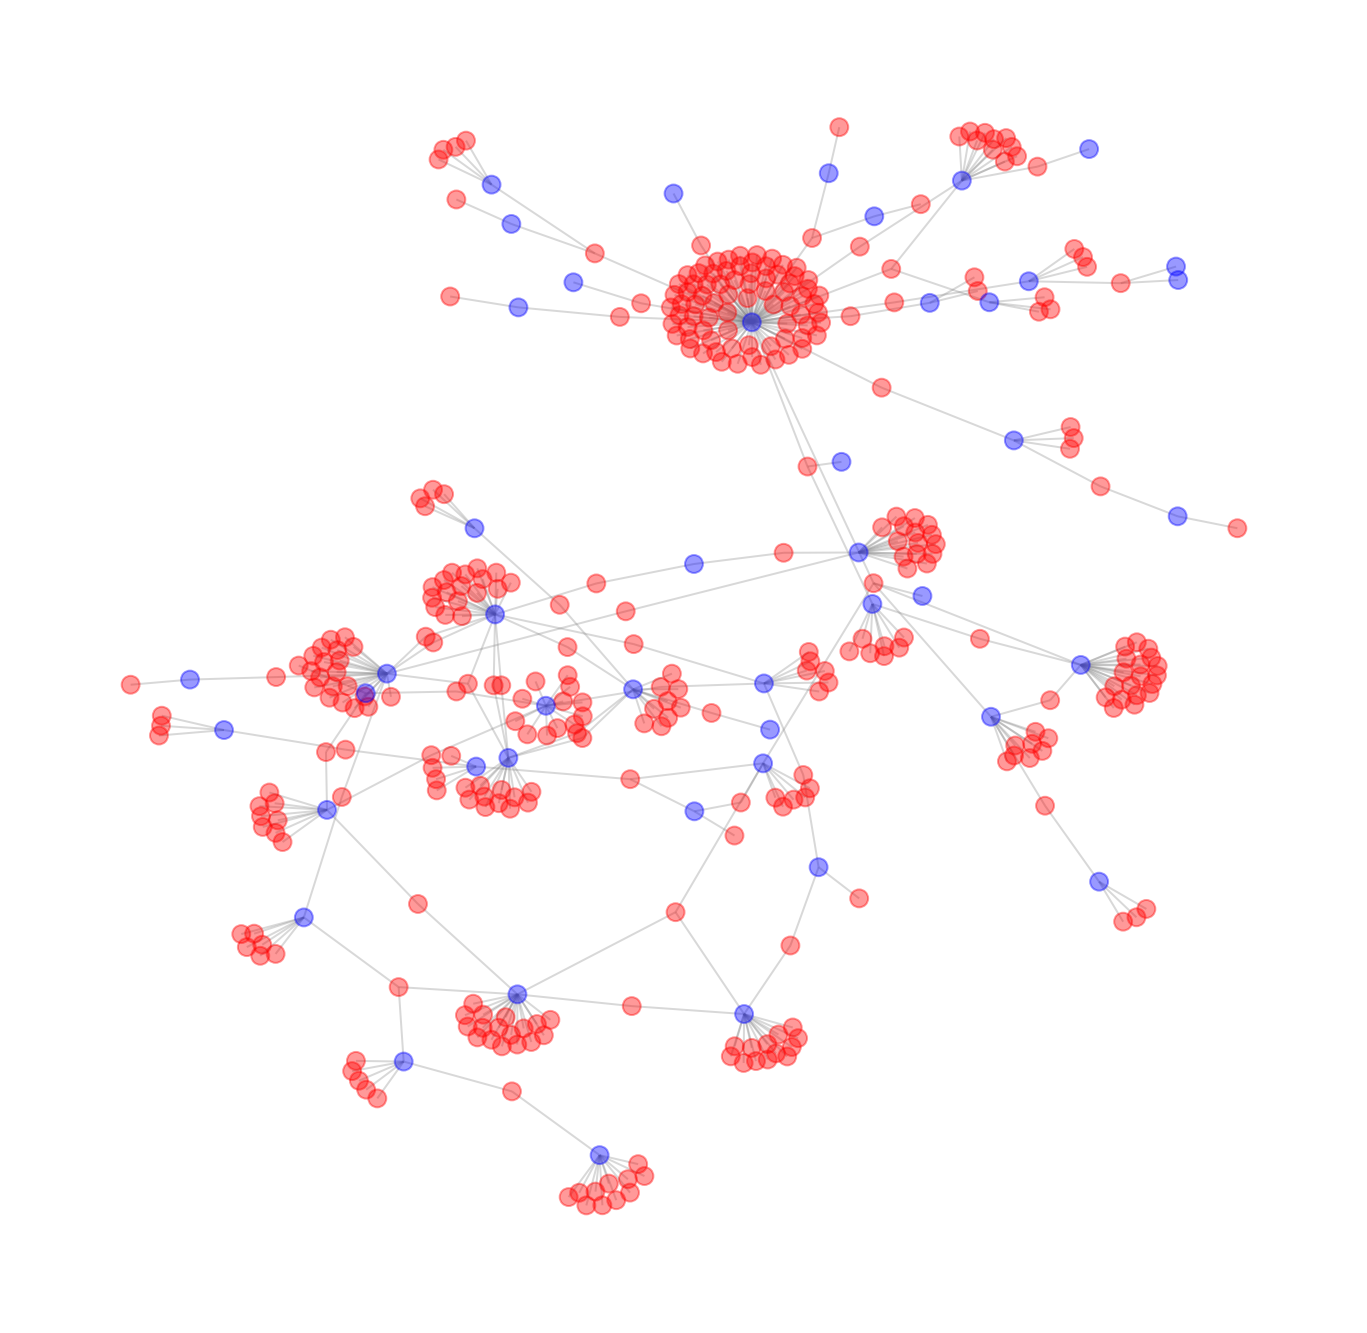

In [52]:
network_1 = subset[subset.host_id.isin(components[1][1])]

# plot network with reviewers added back in
G_net_1 = nx.Graph()
G_net_1.add_nodes_from(network_1.reviewer_id.unique(), bipartite=0)
G_net_1.add_nodes_from(network_1.host_id.unique(), bipartite=1)
G_net_1.add_edges_from(network_1[['reviewer_id', 'host_id']].values)

# nodes
reviewer_nodes = network_1.reviewer_id.unique()
host_nodes = network_1.host_id.unique()
labels = {node: labels_dict[node] for node in G_net_1.nodes}

# create plot
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_net_1, seed=6)
nx.draw_networkx_nodes(G_net_1, pos, node_size=80, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)), alpha=0.4)
nx.draw_networkx_edges(G_net_1, pos, width=1, edge_color='grey', alpha=0.3)
# nx.draw_networkx_labels(G_net_1, pos, labels=labels, font_size=11, font_family="sans-serif",
#                         horizontalalignment='left', verticalalignment='bottom')
plt.axis("off")
plt.show()

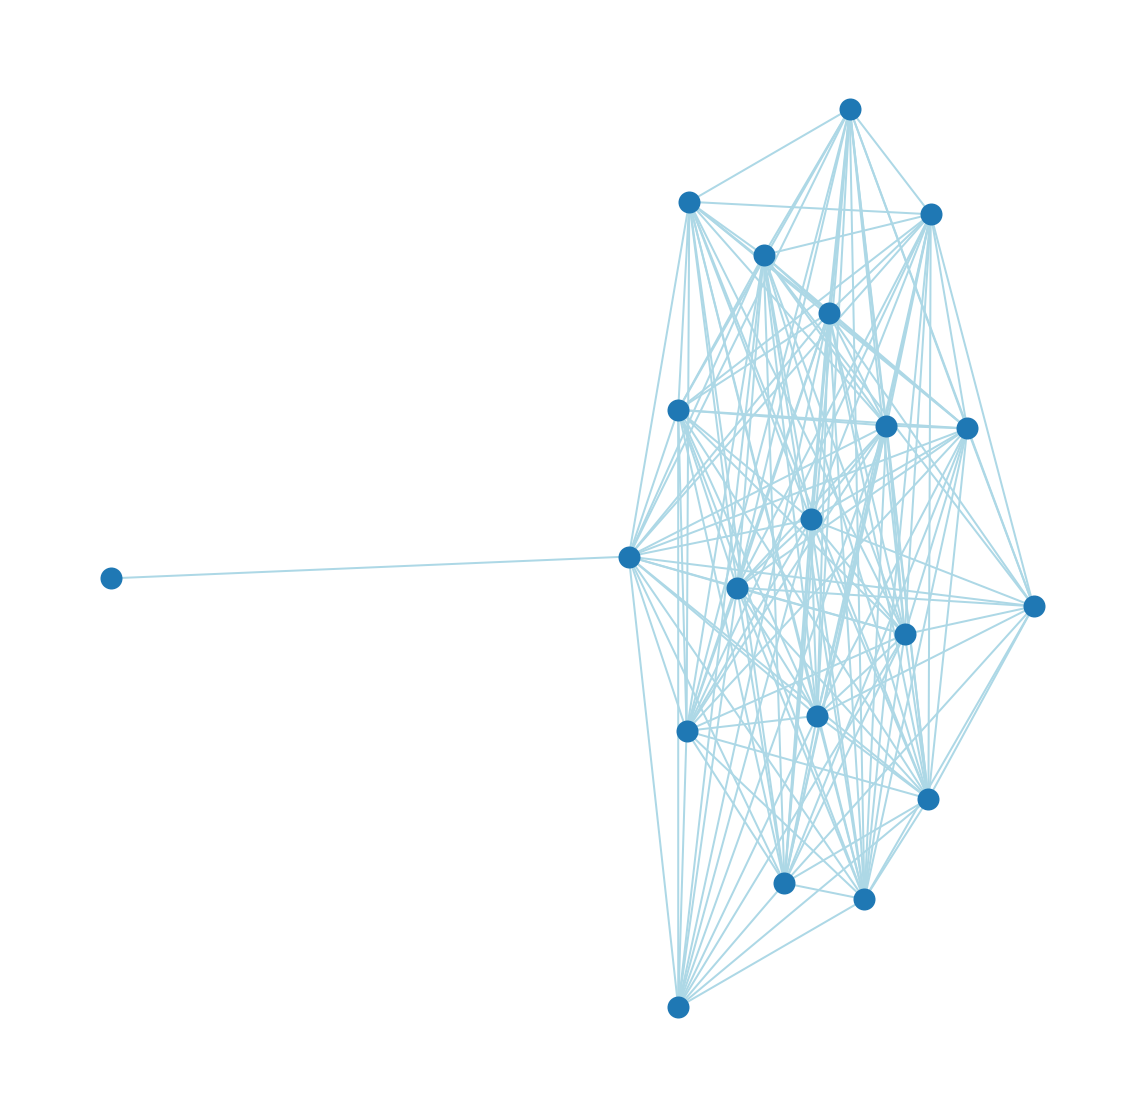

In [53]:
# plot one of the components
B_sub_1 = B.subgraph(components[11][1])

pos = nx.spring_layout(B_sub_1, seed=4)
labels = {node: labels_dict[node] for node in B_sub_1.nodes}

# create plot
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(B_sub_1, pos, node_size=100)
nx.draw_networkx_edges(B_sub_1, pos, width=1, edge_color='lightblue')
# nx.draw_networkx_labels(B_sub_1, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()

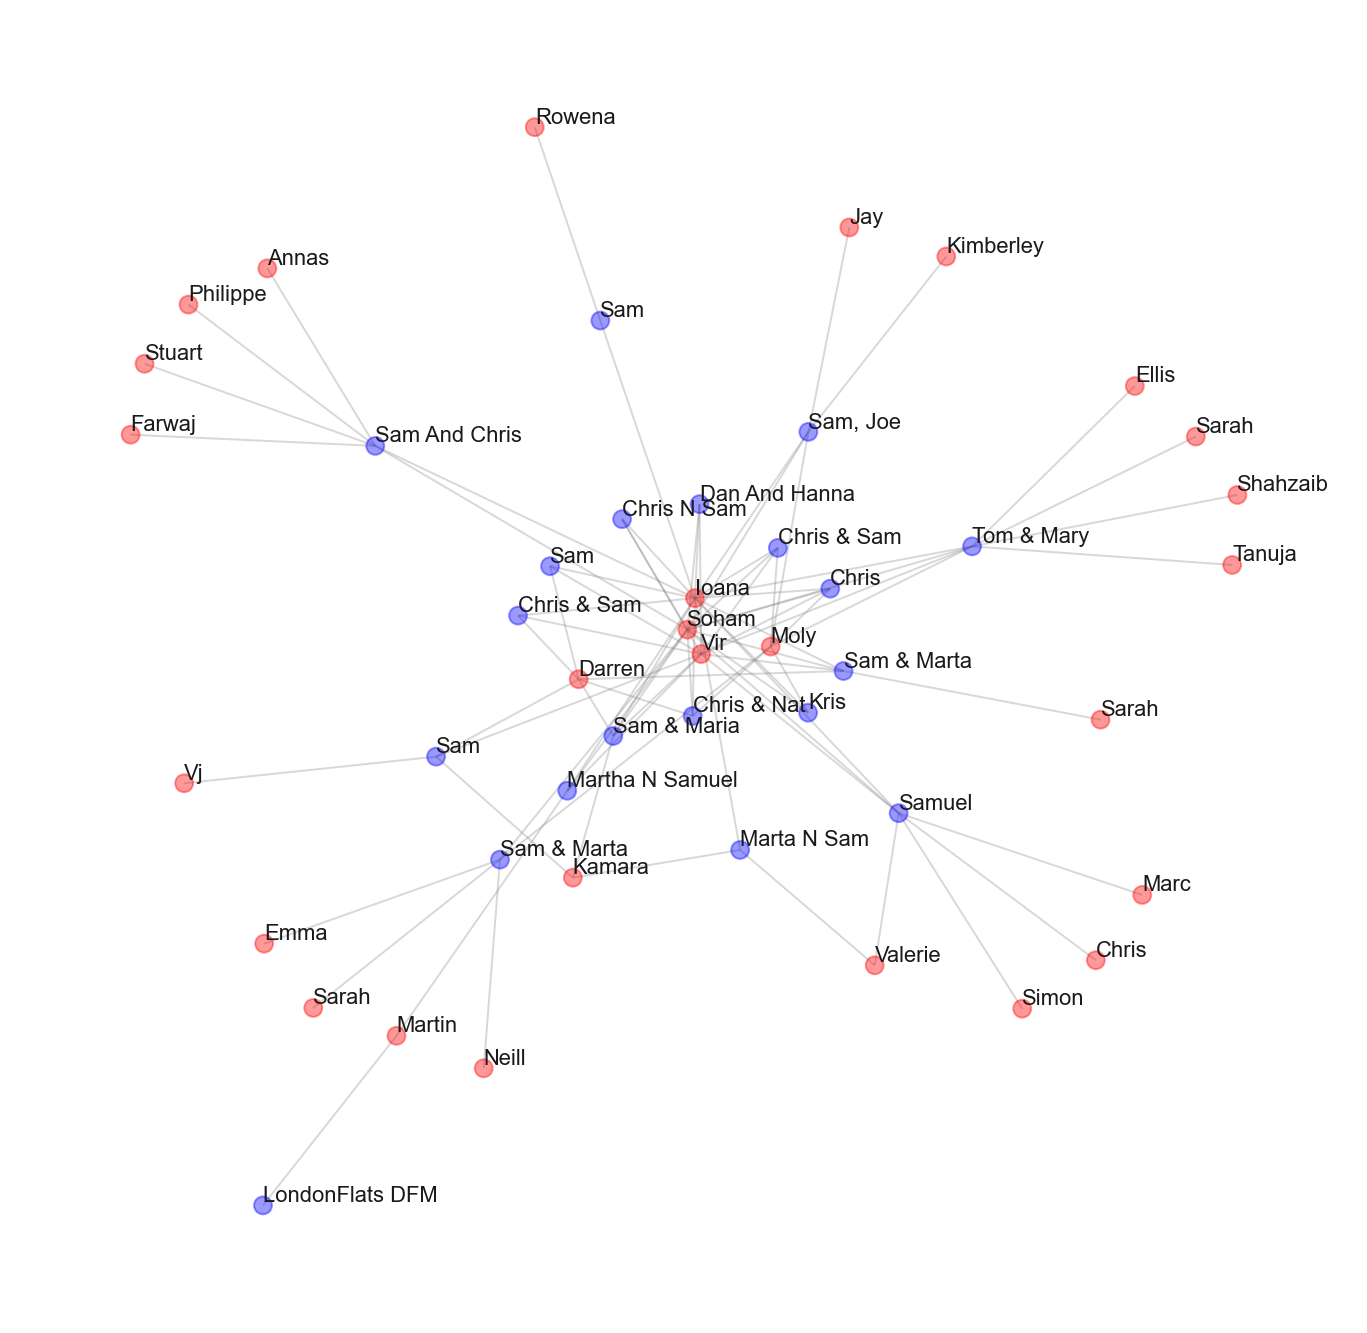

In [54]:
network_1 = subset[subset.host_id.isin(components[11][1])]

# plot network with reviewers added back in
G_net_1 = nx.Graph()
G_net_1.add_nodes_from(network_1.reviewer_id.unique(), bipartite=0)
G_net_1.add_nodes_from(network_1.host_id.unique(), bipartite=1)
G_net_1.add_edges_from(network_1[['reviewer_id', 'host_id']].values)

# nodes
reviewer_nodes = network_1.reviewer_id.unique()
host_nodes = network_1.host_id.unique()
labels = {node: labels_dict[node] for node in G_net_1.nodes}

# create plot
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_net_1, seed=6)
nx.draw_networkx_nodes(G_net_1, pos, node_size=80, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)), alpha=0.4)
nx.draw_networkx_edges(G_net_1, pos, width=1, edge_color='grey', alpha=0.3)
nx.draw_networkx_labels(G_net_1, pos, labels=labels, font_size=11, font_family="sans-serif",
                        horizontalalignment='left', verticalalignment='bottom')
plt.axis("off")
plt.show()

### 3.2 Understanding reviews of "Suspicious hosts"

In [104]:
# df.loc[df['host_id'] == 27787137]

In [62]:
df_main = df
df_susp = df_main.merge(gcc_df, on=['host_id'], how='inner')
df_susp.head()

,listing_id,reviewer_id,reviewer_name,id,date,comments,host_id,host_name,host_review_count,reviewer_review_count,host_listing_count,reviewer_host_count
0,350588,7629823,Damon,94977927,2016-08-17,"We were only in London for a single evening, b...",1775224,Christina,993,2,7,2
1,350588,73234710,Cristina,95369268,2016-08-19,Christina and her husband made us feel welcome...,1775224,Christina,993,1,7,1
2,350588,7585756,Michal,96741112,2016-08-24,Christina has been the best host one can hope ...,1775224,Christina,993,1,7,1
3,350588,47173422,Michael,98669805,2016-09-01,L'immeuble n'est pas loin de la gare et l'endr...,1775224,Christina,993,1,7,1
4,350588,24597923,Zhihao,99716546,2016-09-05,Christina has been a most gracious host! altho...,1775224,Christina,993,1,7,1


In [64]:
df_susp.shape

(55851, 12)

In [80]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize

df_susp.drop_duplicates(subset = 'comments', keep = 'first', inplace = True)
df_susp['comments'] = df_susp['comments'].astype('str')

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df_susp['Polarity'] = df_susp['comments'].apply(get_polarity)

In [83]:
df_susp['Sentiment_Type']=''
df_susp.loc[df_susp.Polarity>0,'Sentiment_Type']='POSITIVE'
df_susp.loc[df_susp.Polarity==0,'Sentiment_Type']='NEUTRAL'
df_susp.loc[df_susp.Polarity<0,'Sentiment_Type']='NEGATIVE'

In [85]:
df_susp_pos = df_susp.loc[df_susp['Sentiment_Type'] == 'POSITIVE']
df_susp_neg = df_susp.loc[df_susp['Sentiment_Type'] == 'NEGATIVE']

### 3.3 WordCloud for Positive & Negative reviews

In [95]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

text = " ".join(review for review in df_susp_neg.comments)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 569355 words in the combination of all review.


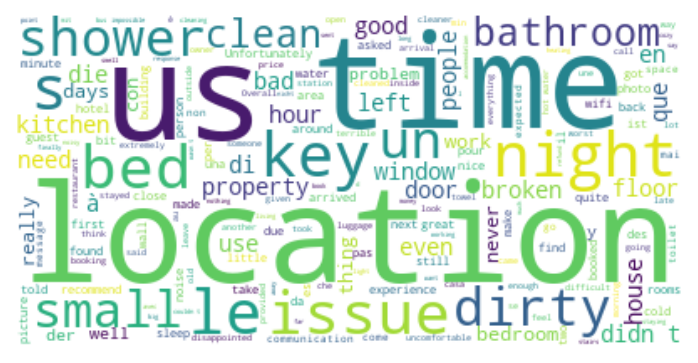

In [101]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["br", "de", "will", "check", "et", "place", "airbnb", "room", "flat", "apartment", "london", "stay", "host", "e", "one", "la", "u", "day", "und"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud of negative reviews

In [103]:
# Save the image in the img folder:
wordcloud.to_file("first_review.png")

There are 11670359 words in the combination of all review.


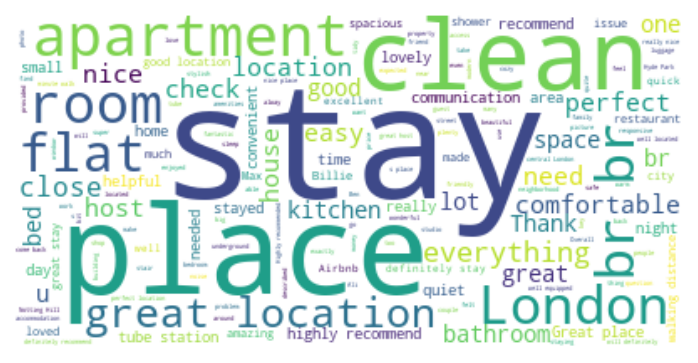

In [105]:
text_pos = " ".join(review for review in df_susp_pos.comments)
print ("There are {} words in the combination of all review.".format(len(text_pos)))

# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["br", "de", "will", "check", "et", "place", "airbnb", "room", "flat", "apartment", "london", "stay", "host", "e", "one", "la", "u", "day", "und"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_pos)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud of positive reviews

-----------------